<a href="https://colab.research.google.com/github/Palak-bansal-26/Natural-Disaster-Prediction/blob/main/Earthquake_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the Dependencies**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [ ]:
earthquake_data = pd.read_csv('/content/Earthquake_Data.csv')

In [ ]:
earthquake_data.head()

,Date(YYYY/MM/DD) Time Latitude Longitude Depth Mag Magt Nst Gap Clo RMS SRC EventID
0,1966/07/01 09:41:21.82 35.9463 -120.4700 12....
1,1966/07/02 12:08:34.25 35.7867 -120.3265 8....
2,1966/07/02 12:16:14.95 35.7928 -120.3353 9....
3,1966/07/02 12:25:06.12 35.7970 -120.3282 9....
4,1966/07/05 18:54:54.36 35.9223 -120.4585 7....


In [ ]:
earthquake_data = earthquake_data.iloc[:, 0].str.split(expand=True)

# Assigning proper column names (assuming the original column names)
earthquake_data.columns = [
    'Date(YYYY/MM/DD)', 'Time', 'Latitude', 'Longitude', 'Depth', 'Mag',
    'Magt', 'Nst', 'Gap', 'Clo', 'RMS', 'SRC', 'EventID'
]
earthquake_data.head()

,Date(YYYY/MM/DD),Time,Latitude,Longitude,Depth,Mag,Magt,Nst,Gap,Clo,RMS,SRC,EventID
0,1966/07/01,09:41:21.82,35.9463,-120.4700,12.26,3.20,Mx,7,171,20,0.02,NCSN,-4540462
1,1966/07/02,12:08:34.25,35.7867,-120.3265,8.99,3.70,Mx,8,86,3,0.04,NCSN,-4540520
2,1966/07/02,12:16:14.95,35.7928,-120.3353,9.88,3.40,Mx,8,89,2,0.03,NCSN,-4540521
3,1966/07/02,12:25:06.12,35.7970,-120.3282,9.09,3.10,Mx,8,101,3,0.08,NCSN,-4540522
4,1966/07/05,18:54:54.36,35.9223,-120.4585,7.86,3.10,Mx,9,161,14,0.04,NCSN,-4540594


In [ ]:
earthquake_data.shape

(10921, 13)

In [ ]:
earthquake_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10921 entries, 0 to 10920
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Date(YYYY/MM/DD)  10921 non-null  object
 1   Time              10921 non-null  object
 2   Latitude          10921 non-null  object
 3   Longitude         10921 non-null  object
 4   Depth             10921 non-null  object
 5   Mag               10921 non-null  object
 6   Magt              10921 non-null  object
 7   Nst               10921 non-null  object
 8   Gap               10921 non-null  object
 9   Clo               10921 non-null  object
 10  RMS               10921 non-null  object
 11  SRC               10921 non-null  object
 12  EventID           10921 non-null  object
dtypes: object(13)
memory usage: 1.1+ MB


In [ ]:
earthquake_data.isnull().sum()

,0
Date(YYYY/MM/DD),0
Time,0
Latitude,0
Longitude,0
Depth,0
Mag,0
Magt,0
Nst,0
Gap,0
Clo,0


In [ ]:
earthquake_data.describe()

,Date(YYYY/MM/DD),Time,Latitude,Longitude,Depth,Mag,Magt,Nst,Gap,Clo,RMS,SRC,EventID
count,10921,10921,10921,10921,10921,10921,10921,10921,10921,10921,10921,10921,10921
unique,4764,10914,7968,8440,2380,210,3,142,328,235,160,1,10921
top,1983/05/03,17:02:52.00,36.5852,-121.5307,5.00,3.00,Md,10,58,3,0.06,NCSN,-4540462
freq,144,2,8,7,250,692,7084,385,123,1050,1365,10921,1


In [ ]:
earthquake_data.nunique()

,0
Date(YYYY/MM/DD),4764
Time,10914
Latitude,7968
Longitude,8440
Depth,2380
Mag,210
Magt,3
Nst,142
Gap,328
Clo,235


**Data Preprocessing**

In [ ]:
earthquake_data = earthquake_data.drop_duplicates()

In [ ]:
# convert data types (Example: Convert Date and Time to datetime)
earthquake_data['Datetime'] = pd.to_datetime(earthquake_data['Date(YYYY/MM/DD)'] + ' ' + earthquake_data['Time'])
earthquake_data = earthquake_data.drop(columns=['Date(YYYY/MM/DD)', 'Time'])


In [ ]:
# Feature engineering (Example: Extract year, month, day, hour)
earthquake_data['Year'] = earthquake_data['Datetime'].dt.year
earthquake_data['Month'] = earthquake_data['Datetime'].dt.month
earthquake_data['Day'] = earthquake_data['Datetime'].dt.day
earthquake_data['Hour'] = earthquake_data['Datetime'].dt.hour


In [ ]:
# Convert the 'Depth' column to numeric, coercing errors to NaN (to handle any non-numeric values)
earthquake_data['Depth'] = pd.to_numeric(earthquake_data['Depth'], errors='coerce')

# Drop rows where 'Depth' could not be converted to a numeric type (optional, if such rows exist)
earthquake_data = earthquake_data.dropna(subset=['Depth'])

# Outlier detection (Example: Remove extreme outliers)
earthquake_data = earthquake_data[(np.abs(earthquake_data['Depth'] - earthquake_data['Depth'].mean()) <= (3*earthquake_data['Depth'].std()))]


In [ ]:
# Normalization/Standardization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(earthquake_data[['Latitude', 'Longitude', 'Depth', 'Mag']])


In [ ]:
# Encoding categorical variables (Example: One-hot encoding)
earthquake_data = pd.get_dummies(earthquake_data, columns=['Magt', 'SRC'])


In [ ]:
# Split the data
X = earthquake_data.drop(columns=['EventID', 'Datetime'])
y = earthquake_data['Mag']  # Example target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Step 12: Correlation analysis
correlation_matrix = X_train.corr()
print("Correlation matrix:\n", correlation_matrix)


Correlation matrix:
            Latitude  Longitude     Depth       Mag       Nst       Gap  \
Latitude   1.000000  -0.564568  0.274103 -0.045555 -0.128706  0.330359   
Longitude -0.564568   1.000000 -0.266852  0.053612 -0.100877 -0.144866   
Depth      0.274103  -0.266852  1.000000  0.017052 -0.029989  0.221204   
Mag       -0.045555   0.053612  0.017052  1.000000  0.132723  0.035721   
Nst       -0.128706  -0.100877 -0.029989  0.132723  1.000000 -0.409232   
Gap        0.330359  -0.144866  0.221204  0.035721 -0.409232  1.000000   
Clo        0.294408  -0.176085 -0.006042  0.093863 -0.096779  0.617058   
RMS        0.011224   0.022917 -0.024914  0.025272  0.003741  0.065953   
Year       0.188783   0.108725  0.092405 -0.006096  0.323217  0.131918   
Month      0.071802  -0.015413  0.026539  0.008359  0.010899 -0.009645   
Day       -0.007015   0.028822 -0.000089  0.026203  0.003049 -0.012189   
Hour      -0.007679   0.013110 -0.024523 -0.001253 -0.019139 -0.008917   
Magt_ML    0.2364

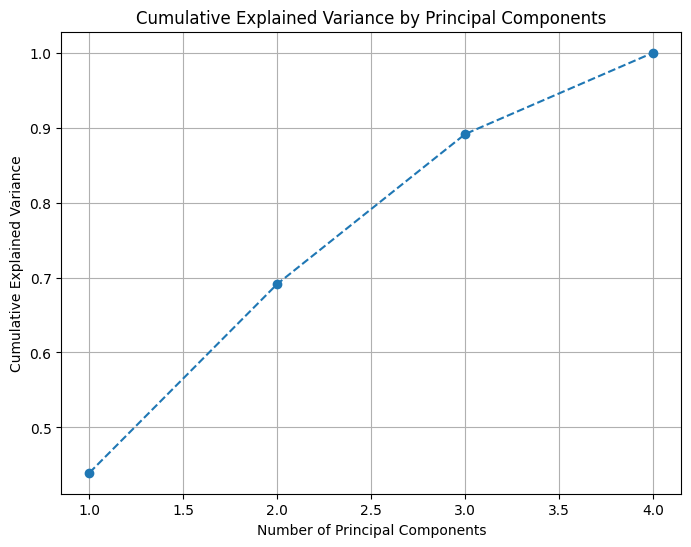

In [ ]:
#  Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
principal_components = pca.fit_transform(scaled_features)

# Explained variance ratio to understand how much variance is explained by each principal component
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance to decide how many components to keep
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()



In [ ]:
# After PCA, the transformed dataset is now in 'principal_components'
print("Shape of data after PCA:", principal_components.shape)


Shape of data after PCA: (10757, 4)


In [ ]:
print(X_train, X_test, y_train, y_test)

     Latitude  Longitude  Depth   Mag  Nst  Gap Clo   RMS  Year  Month  Day  \
5289  37.6288  -118.8148   6.44  3.22    5  121   4  0.08  1980      6   25   
6995  36.2465  -120.3648   9.02  3.17   39  128  36  0.12  1983      5    3   
2987  36.9240  -121.4670   3.06  3.21   37   55   4  0.14  1975      4    1   
9222  40.3580  -124.4318  19.41  3.01   14  227  15  0.09  1986     11   22   
4382  38.6305  -121.9027  10.64  4.20  124   45  26  0.19  1978      9    8   
...       ...        ...    ...   ...  ...  ...  ..   ...   ...    ...  ...   
5801  35.9563  -120.5027  10.26  3.10   40   77   3  0.06  1981      1   11   
5252  37.6230  -118.8937   5.51  3.50   13  100   1  0.05  1980      6   14   
5451  37.5825  -118.8790   5.87  3.07    6  150   5  0.07  1980      8    4   
863   36.6938  -121.3268   4.38  3.91   12   95   2  0.05  1971     12   29   
7368  36.2828  -120.4175   8.73  4.27   44   65   7  0.09  1983      8   14   

      Hour  Magt_ML  Magt_Md  Magt_Mx  SRC_NCSN  
5

**Training Models**

**Linear Regression**

In [ ]:

# Ensure that y_test and y_pred_lr are numeric
y_test_numeric = pd.to_numeric(y_test, errors='coerce')
y_pred_numeric = pd.to_numeric(y_pred_lr, errors='coerce')

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Evaluation
mse_lr = mean_squared_error(y_test_numeric, y_pred_lr)
r2_lr = r2_score(y_test_numeric, y_pred_lr)
print(f"Linear Regression - MSE: {mse_lr}, R²: {r2_lr}")

# Discretize (round) the predicted and actual values for accuracy calculation
y_pred_discretized = np.round(y_pred_lr)
y_test_discretized = np.round(y_test_numeric)

# Calculate accuracy
accuracy = accuracy_score(y_test_discretized, y_pred_discretized)
print(f"Linear Regression - Accuracy: {accuracy * 100:.2f}%")


Linear Regression - MSE: 4.306925775625159e-29, R²: 1.0
Linear Regression - Accuracy: 97.77%


**Random Forest Regressor**

In [ ]:
# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MSE: {mse_rf}, R²: {r2_rf}")

# Ensure that y_test and y_pred_rf are numeric
y_test_numeric = pd.to_numeric(y_test, errors='coerce')
y_pred_numeric = pd.to_numeric(y_pred_rf, errors='coerce')

# Discretize (round) the predicted and actual values for accuracy calculation
y_pred_discretized = np.round(y_pred_numeric)
y_test_discretized = np.round(y_test_numeric)

# Calculate accuracy
accuracy = accuracy_score(y_test_discretized, y_pred_discretized)
print(f"Random Forest - Accuracy: {accuracy * 100:.2f}%")


Random Forest - MSE: 2.4231045539035615e-05, R²: 0.9998715899712425
Random Forest - Accuracy: 100.00%


**Support Vector Regressor**

In [ ]:
# Support Vector Regressor
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)

# Evaluation
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print(f"SVR - MSE: {mse_svr}, R²: {r2_svr}")

# Ensure that y_test and y_pred_svr are numeric
y_test_numeric = pd.to_numeric(y_test, errors='coerce')
y_pred_numeric = pd.to_numeric(y_pred_svr, errors='coerce')

# Discretize (round) the predicted and actual values for accuracy calculation
y_pred_discretized = np.round(y_pred_numeric)
y_test_discretized = np.round(y_test_numeric)

# Calculate accuracy
accuracy = accuracy_score(y_test_discretized, y_pred_discretized)
print(f"SVR - Accuracy: {accuracy * 100:.2f}%")


SVR - MSE: 0.1959814873627443, R²: -0.0385845046449671
SVR - Accuracy: 65.85%


**Gradient Boosting Regressor**

In [ ]:
# Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)

# Evaluation
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)
print(f"Gradient Boosting - MSE: {mse_gbr}, R²: {r2_gbr}")

# Ensure that y_test and y_pred_gbr are numeric
y_test_numeric = pd.to_numeric(y_test, errors='coerce')
y_pred_numeric = pd.to_numeric(y_pred_gbr, errors='coerce')

# Discretize (round) the predicted and actual values for accuracy calculation
y_pred_discretized = np.round(y_pred_numeric)
y_test_discretized = np.round(y_test_numeric)

# Calculate accuracy
accuracy = accuracy_score(y_test_discretized, y_pred_discretized)
print(f"Gradient Boosting - Accuracy: {accuracy * 100:.2f}%")


Gradient Boosting - MSE: 1.99680922222899e-05, R²: 0.9998941810706283
Gradient Boosting - Accuracy: 95.96%


**Comparing Model Performance**

Text(0.5, 0, 'MSE')

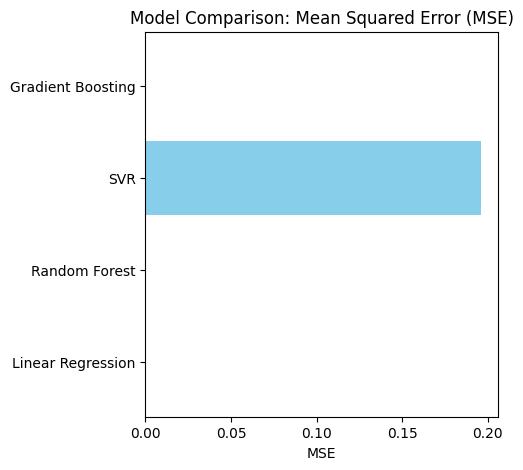

In [ ]:
# Comparing Model Performance
models = ['Linear Regression', 'Random Forest', 'SVR', 'Gradient Boosting']
mse_values = [mse_lr, mse_rf, mse_svr, mse_gbr]
r2_values = [r2_lr, r2_rf, r2_svr, r2_gbr]

# Plotting MSE Comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.barh(models, mse_values, color='skyblue')
plt.title('Model Comparison: Mean Squared Error (MSE)')
plt.xlabel('MSE')


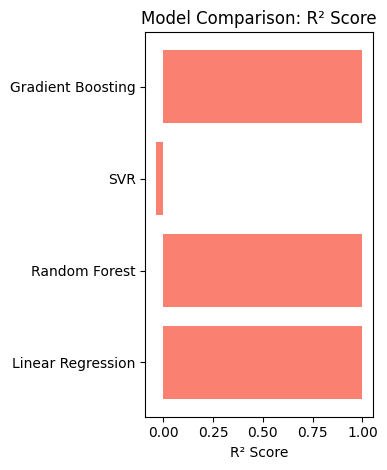

In [ ]:
# Plotting R² Comparison
plt.subplot(1, 2, 2)
plt.barh(models, r2_values, color='salmon')
plt.title('Model Comparison: R² Score')
plt.xlabel('R² Score')

plt.tight_layout()
plt.show()


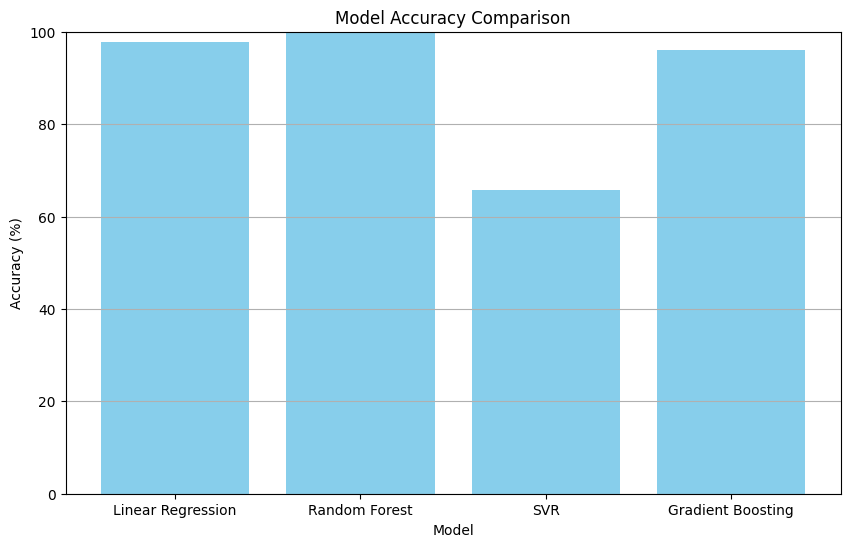

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR(kernel='rbf'),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Dictionary to store accuracy values
accuracy_scores = {}

for name, model in models.items():
    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Ensure y_test and y_pred are numeric
    y_test_numeric = pd.to_numeric(y_test, errors='coerce')
    y_pred_numeric = pd.to_numeric(y_pred, errors='coerce')

    # Discretize (round) the predicted and actual values
    y_pred_discretized = np.round(y_pred_numeric)
    y_test_discretized = np.round(y_test_numeric)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_discretized, y_pred_discretized)
    accuracy_scores[name] = accuracy * 100  # Convert to percentage

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 100)  # Assuming accuracy is in percentage
plt.grid(axis='y')

# Display the plot
plt.show()
